# Setup Files

the file dictionary consists of a key name for the trajectory, the path to the data and an additional Unit if it is not given in the trajectory data 

In [1]:
from pedpy import TrajectoryUnit
files = {"unidirectional 1": ("demo-data/uni-directional/traj_UNI_CORR_500_08.txt", TrajectoryUnit.METER),
         "unidirectional 2": ("demo-data/uni-directional/traj_UNI_CORR_500_03.txt", TrajectoryUnit.METER),
         "bidirectional 1": ("demo-data/bi-directional/bi_corr_400_b_08.txt", None),
         "bidirectional 2": ("demo-data/bi-directional/bi_corr_400_b_03.txt", None)}

## load trajectories

In [2]:
from pedpy import load_trajectory
import pathlib

trajectories = {}
for name, (path, unit) in files.items():
    trajectories[name] = load_trajectory(
        trajectory_file=pathlib.Path(path),
        default_unit=unit)
    

## Define Geometries and Measurement lines

In [3]:
from pedpy import WalkableArea

walkable_areas = {
    "unidirectional 1": WalkableArea([(-5.5, 0), (5, 0), (5, 5), (-5.5, 5)]),
    "unidirectional 2": WalkableArea([(-5.5, 0), (5, 0), (5, 5), (-5.5, 5)]),
    "bidirectional 1": WalkableArea([(-6.0, 0), (5, 0), (5, 4), (-6, 4)]),
    "bidirectional 2": WalkableArea([(-6.0, -0.5), (5, 0), (5, 4), (-6, 4.5)])
}

the measurement line defines where we want to measure characteristics of the experimental data

In [4]:
from pedpy import MeasurementLine
measurement_lines = {
    "unidirectional 1": MeasurementLine([(0.0, 0.0), (0.0, 5.0)]),
    "unidirectional 2": MeasurementLine([(0.0, 0.0), (0.0, 5.0)]),
    "bidirectional 1": MeasurementLine([(0.0, 0.0), (0.0, 4.0)]),
    "bidirectional 2": MeasurementLine([(0.0, 0.0), (0.0, 4.0)])
}

## Plot trajectories, geometry, and measurement areas/lines

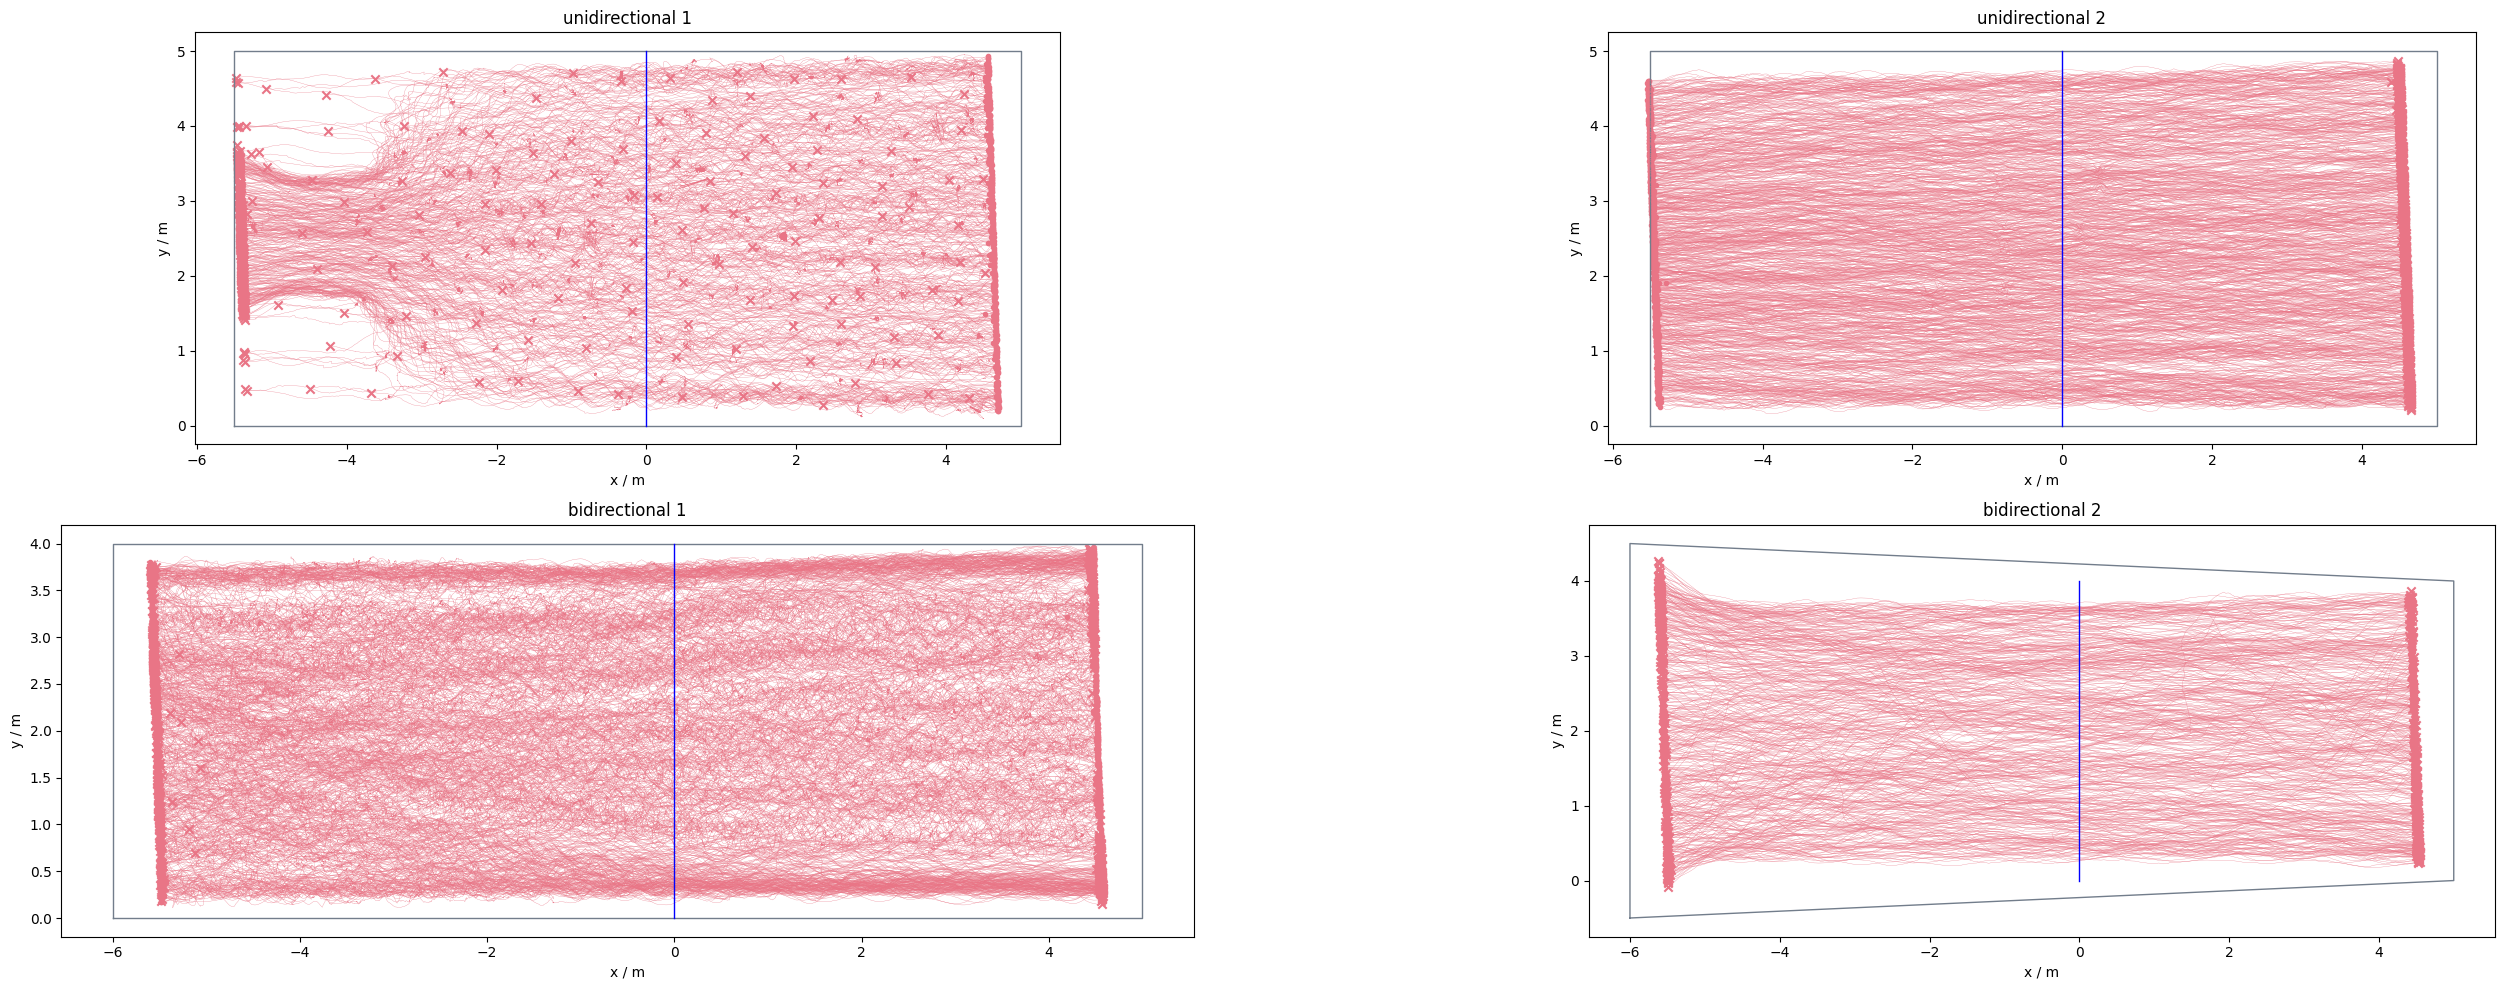

In [5]:
import matplotlib.pyplot as plt
from pedpy import plot_measurement_setup

fig, axs = plt.subplots(2, int(len(trajectories)/2), figsize=(30, 10))

for (name, trajectory), ax in zip(trajectories.items(), axs.ravel()):
    ax.set_title(name)

    ax = plot_measurement_setup(
        traj=trajectory,
        walkable_area=walkable_areas[name],
        measurement_lines=[measurement_lines[name]],
        axes=ax,
        traj_width=0.2,
        traj_start_marker=".",
        traj_end_marker="x",
        ma_color="g",
        ma_line_color="g",
        ma_alpha=0.2,
        ml_color="b",
    )
    ax.set_aspect("equal")

fig.tight_layout()
plt.show()

## Calculate Voronoi Polygons and individual Speed

(this can take some time)

In [6]:
from pedpy.methods.method_utils import compute_individual_voronoi_polygons, Cutoff
from pedpy.methods.speed_calculator import compute_individual_speed

individual_cutoffs = {}
individual_speeds = {}

for name in trajectories:
    individual_cutoffs[name] = compute_individual_voronoi_polygons(
        traj_data=trajectories[name],
        walkable_area=walkable_areas[name],
        cut_off=Cutoff(radius=0.8, quad_segments=3)
    )
    individual_speeds[name] = compute_individual_speed(
        traj_data=trajectories[name],
        frame_step=1,
        compute_velocity=True,
    )

## determine the Species for each agent

the species decides from what side the agents are encountering the measurement line

In [7]:
from pedpy.methods.flow_calculator import separate_species

species = {}

for name in trajectories:
    species[name] = separate_species(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        traj=trajectories[name],
        frame_step=25)

## Compute speed at line

In [8]:
from pedpy.methods.flow_calculator import calc_speed_on_line

speeds = {}
for name in trajectories:
    speeds[name] = calc_speed_on_line(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        individual_speed=individual_speeds[name],
        species=species[name]) 

## plot speed on the line

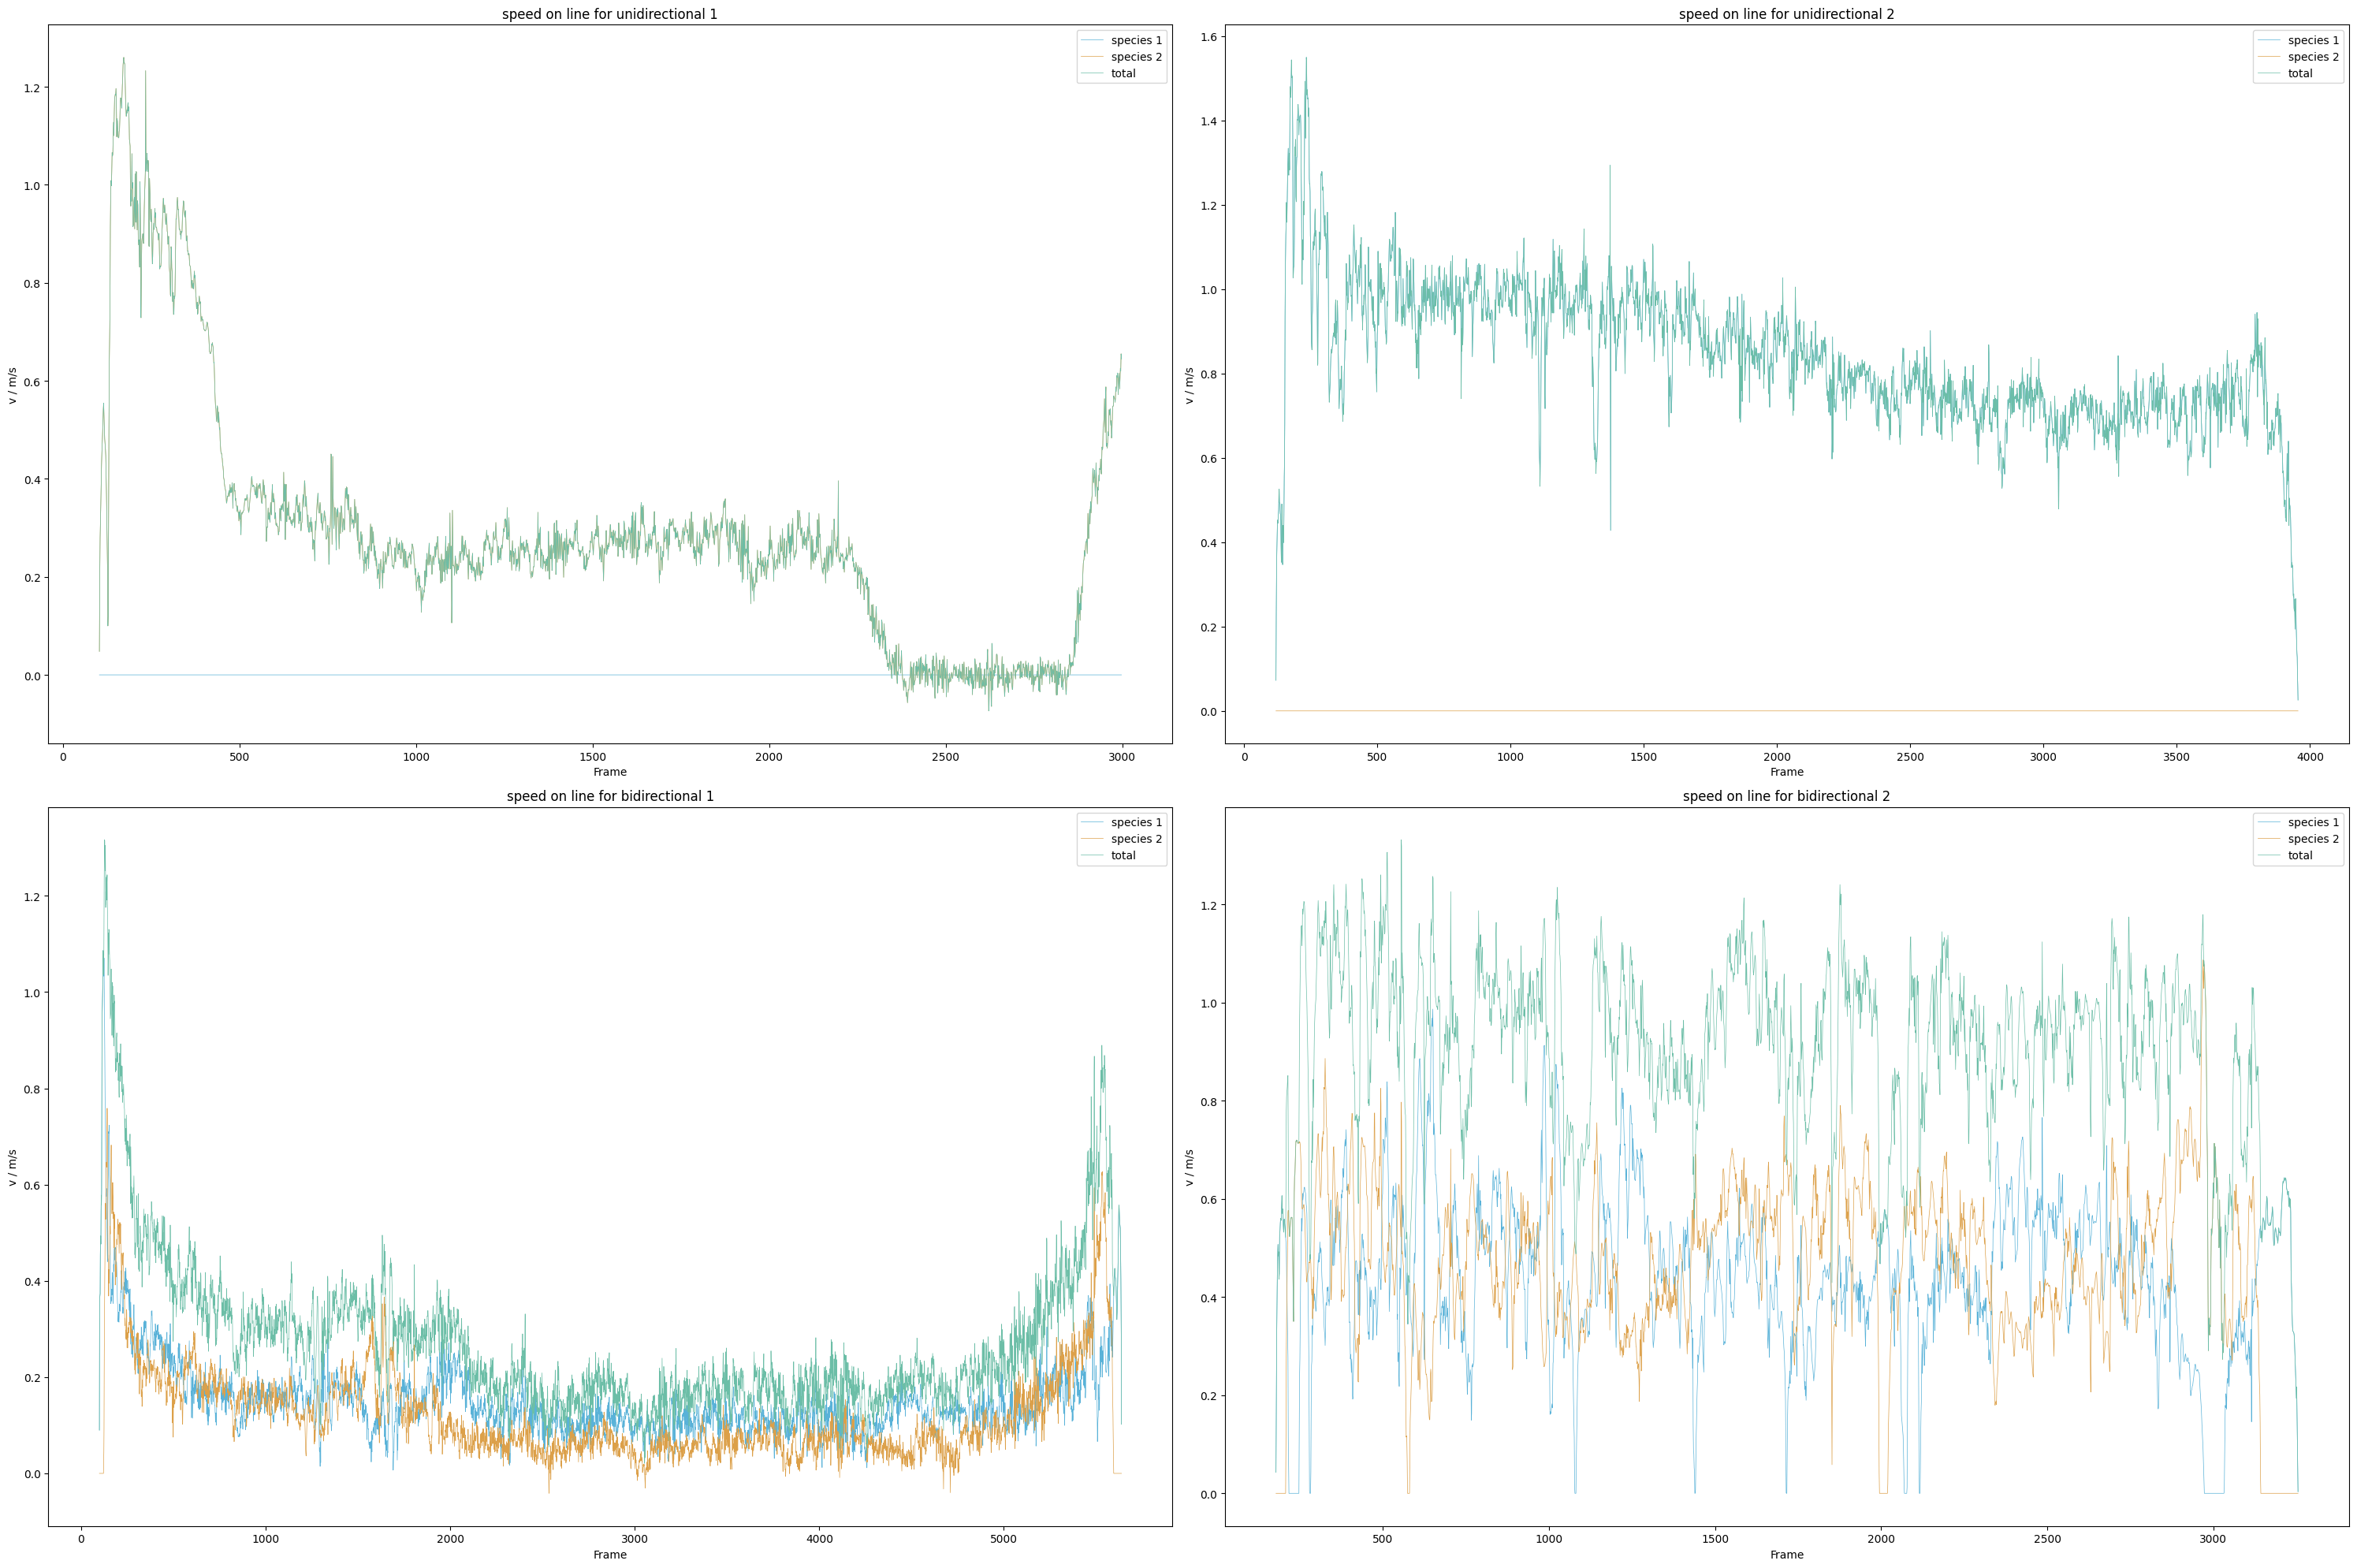

In [9]:
from pedpy.plotting.plotting import plot_speed_at_line
import matplotlib.pylab as plt

fig, axs = plt.subplots(2, int(len(speeds)/2), figsize=(30, 20))

for (name, speed_on_line), ax in zip(speeds.items(), axs.ravel()):
    
    ax = plot_speed_at_line(
            speed_at_line=speed_on_line,
            axes=ax,
            line_width=0.5,
            title="speed on line for "+name
        )

fig.tight_layout()
plt.show()
    

## Compute Density on the Line

In [10]:
from pedpy.methods.flow_calculator import calc_density_on_line

densities = {}
for name in trajectories:
    densities[name] = calc_density_on_line(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        species=species[name]) 

## Plot Densities on the Line

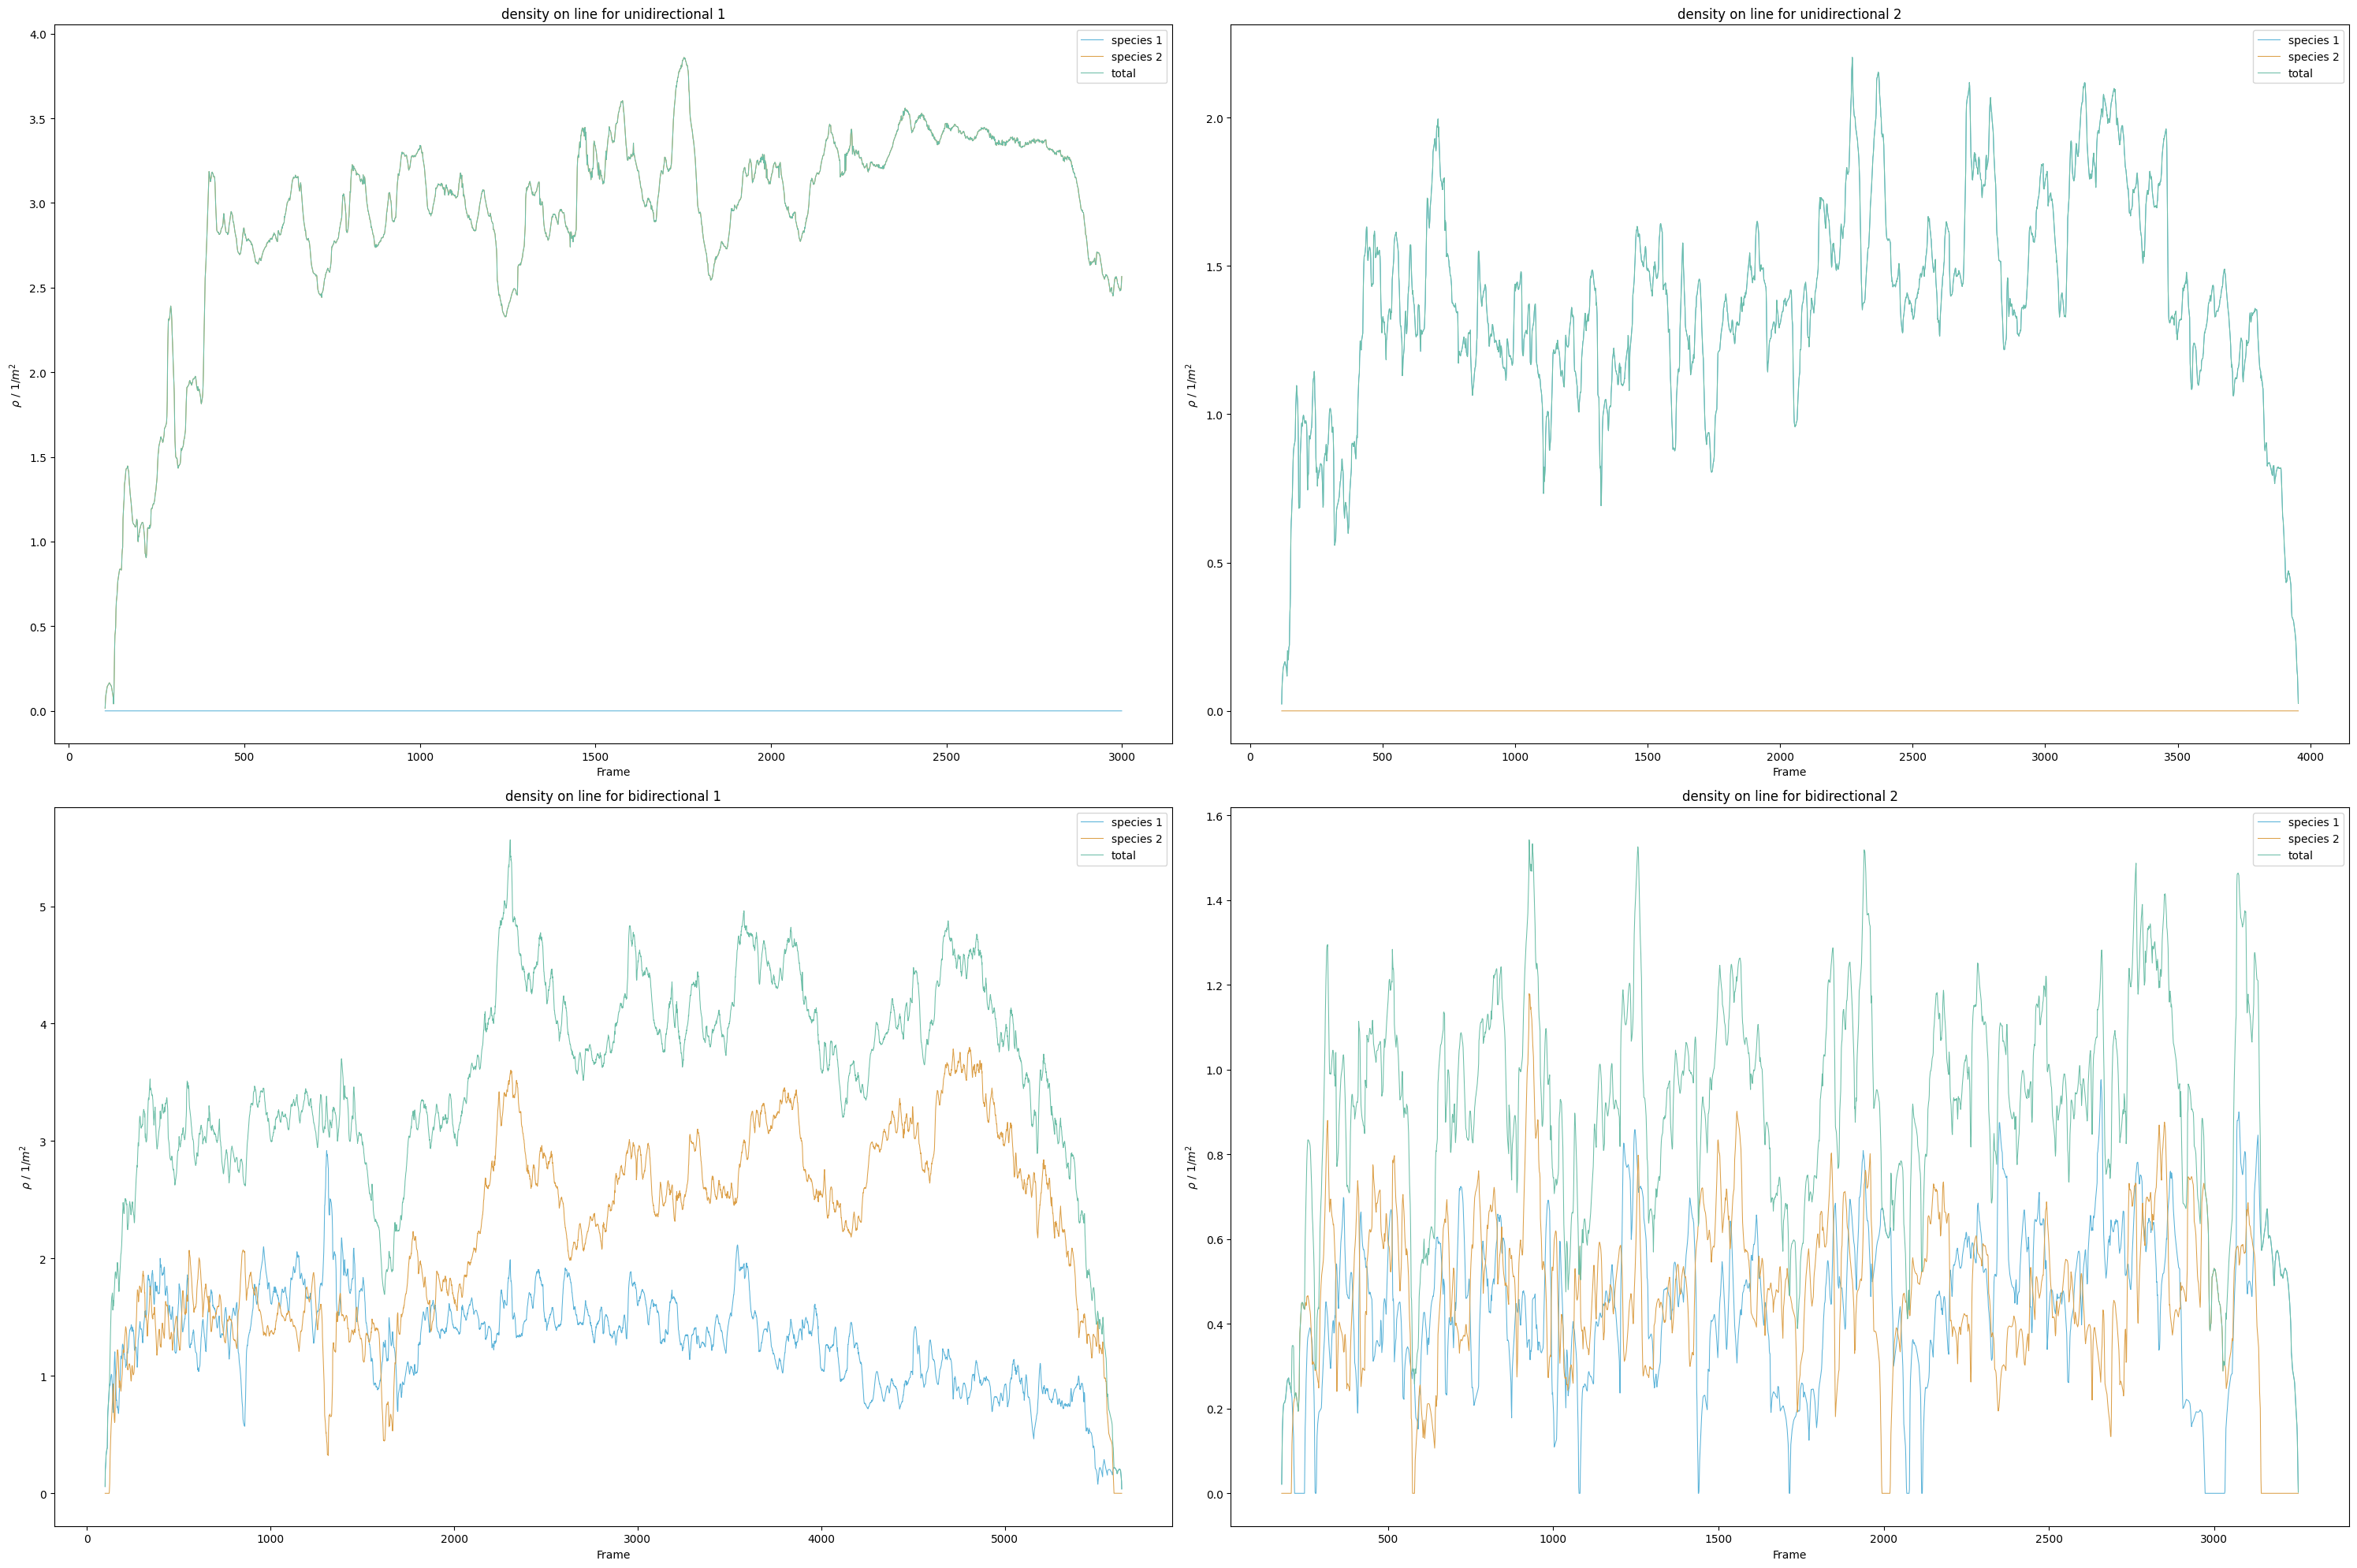

In [11]:
from pedpy.plotting.plotting import plot_density_at_line
import matplotlib.pylab as plt

fig, axs = plt.subplots(2, int(len(densities)/2), figsize=(30, 20))

for (name, density_on_line), ax in zip(densities.items(), axs.ravel()):
    
    ax = plot_density_at_line(
            density_at_line=density_on_line,
            axes=ax,
            line_width=0.75,
            title="density on line for "+name
        )

fig.tight_layout()
plt.show()

## Calculate Flow on Line

In [12]:
from pedpy.methods.flow_calculator import calc_flow_on_line

flows = {}
for name in trajectories:
    flows[name] = calc_flow_on_line(
        individual_voronoi_polygons=individual_cutoffs[name],
        measurement_line=measurement_lines[name],
        species=species[name],
        individual_speed=individual_speeds[name]) 

## Plot Flow on Line

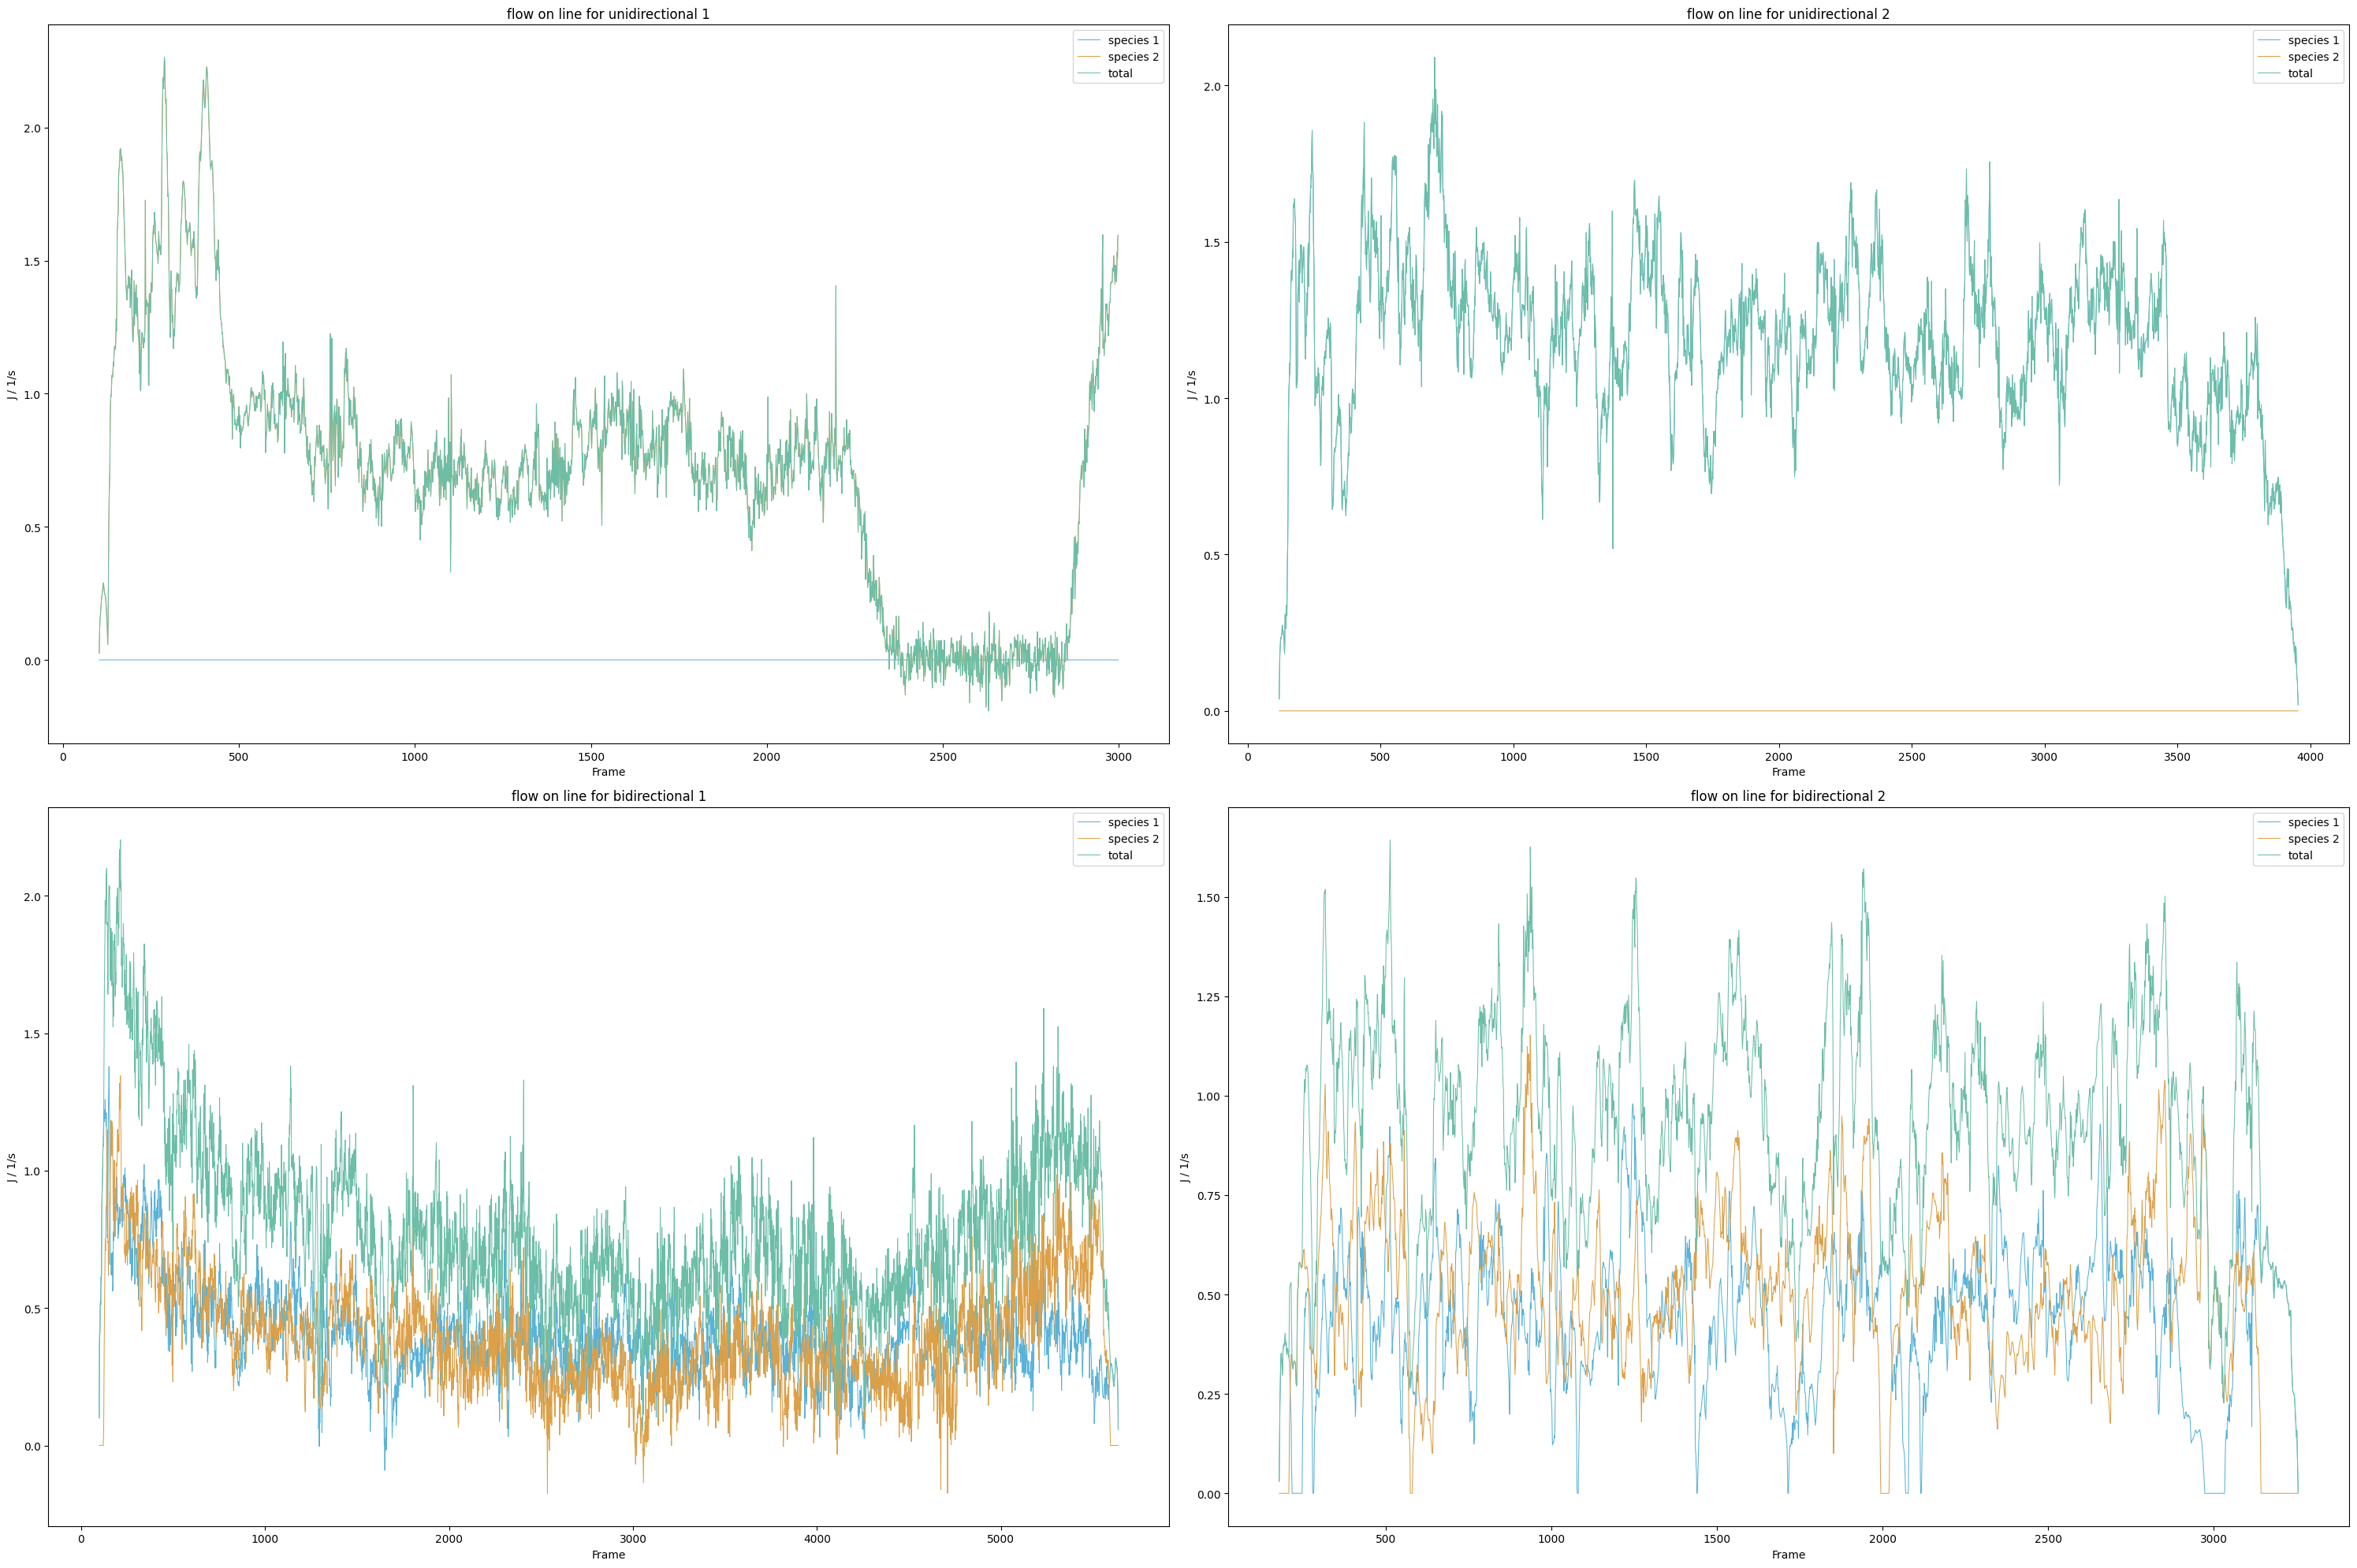

In [13]:
from pedpy.plotting.plotting import plot_flow_at_line
import matplotlib.pylab as plt

fig, axs = plt.subplots(2, int(len(flows)/2), figsize=(30, 20))

for (name, flow_on_line), ax in zip(flows.items(), axs.ravel()):
    
    ax = plot_flow_at_line(
            flow_at_line=flow_on_line,
            axes=ax,
            line_width=0.75,
            title="flow on line for "+name
        )

fig.tight_layout()
plt.show()